# Real-time video segmentation

## Setup environment

In [3]:
!python -c "import monai" || pip install -q "monai-weekly[pillow, ignite, tqdm]"
!python -c "import matplotlib" || pip install -q matplotlib
!python -c "import synapseclient" || pip install -q synapseclient
%matplotlib inline

Traceback (most recent call last):
  File "<string>", line 1, in <module>
ModuleNotFoundError: No module named 'synapseclient'


## Imports

In [4]:
from glob import glob
import os
import synapseclient
import synapseutils
import tempfile

from functools import partial
from glob import glob
import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
import os
import random
import tempfile
import torch
from tqdm import tqdm

import monai
from monai.apps import download_and_extract
from monai.data import (
    BatchInverseTransform,
    CacheDataset,
    DataLoader,
    Dataset,
    pad_list_data_collate,
)
from monai.inferers import sliding_window_inference
from monai.losses import DiceLoss
from monai.metrics import DiceMetric
from monai.networks import eval_mode
from monai.networks.nets import UNet
from monai.transforms import (
    Activations,
    AddChanneld,
    AsChannelFirstd,
    AsDiscrete,
    AsDiscreted,
    Compose,
    CropForegroundd,
    DivisiblePadd,
    KeepLargestConnectedComponent,
    Lambda,
    Lambdad,
    LoadImaged,
    MapTransform,
    RandAffined,
    RandCropByPosNegLabeld,
    ScaleIntensityd,
    ToTensord,
)
from monai.utils import first, set_determinism

monai.config.print_config()

# Set deterministic training for reproducibility
set_determinism(seed=0)

MONAI version: 0.4.0+185.g06e1e99
Numpy version: 1.20.1
Pytorch version: 1.8.1+cu102
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: 06e1e990b03a763ac0a1da0e37917f991e3901cf

Optional dependencies:
Pytorch Ignite version: 0.4.4
Nibabel version: 3.2.1
scikit-image version: 0.18.1
Pillow version: 8.1.2
Tensorboard version: 2.4.1
gdown version: 3.12.2
TorchVision version: 0.9.1+cu102
ITK version: 5.1.2
tqdm version: 4.51.0
lmdb version: 1.1.1
psutil version: 5.8.0

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



## Setup data directory

You can specify a directory with the `MONAI_DATA_DIRECTORY` environment variable.  
This allows you to save results and reuse downloads.  
If not specified a temporary directory will be used.

In [5]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

/home/rbrown/data/MONAI


## Download data from synapse

In [6]:
data_dir = os.path.join(root_dir, "endovis_2017")
train_dir = os.path.join(data_dir, "train")
val_dir = os.path.join(data_dir, "val")

if not os.path.isfile(os.path.join(data_dir, "SYNAPSE_METADATA_MANIFEST.tsv")):
    syn_user = os.environ.get("SYNAPSE_USER")
    syn_pwd = os.environ.get("SYNAPSE_PWD")
    project_id = "syn22410924"  # https://www.synapse.org/#!Synapse:syn22410924

    os.makedirs(data_dir, exist_ok=True)
    syn = synapseclient.login(email=syn_user, password=syn_pwd, rememberMe=True)
    _ = synapseutils.syncFromSynapse(syn, entity=project_id, path=data_dir)

In [7]:
def get_data(folder):
    images = sorted(glob(os.path.join(folder, "*[!seg].png")))
    labels = sorted(glob(os.path.join(folder, "*_seg.png")))
    return [{"image": i, "label": l} for i, l in zip(images, labels)]

train_file_dict = get_data(train_dir)
val_file_dict = get_data(val_dir)

print("Num training image/label pairs", len(train_file_dict))
print("Num validation image/label pairs", len(val_file_dict))

Num training image/label pairs 1616
Num validation image/label pairs 184


In [8]:
class SingleRandCropByPosNegLabeld(RandCropByPosNegLabeld):
    def __call__(self, data):
        d = super().__call__(data)
        return d if self.num_samples > 1 else d[0]

keys = ["image", "label"]
orig_size = np.array(LoadImaged(keys)(train_file_dict[0])["image"].shape[:-1])
train_size = orig_size // 2
val_size = np.ceil(np.array(orig_size) / 16.0) * 16.0
print("orig_size", orig_size)
print("train_size", train_size)
print("val_size", val_size)

train_transforms = Compose([
    LoadImaged(keys),
    AsChannelFirstd("image"),
    AddChanneld("label"),
    SingleRandCropByPosNegLabeld(
        keys,
        label_key="label",
        spatial_size=train_size,
        pos=1.0,
        neg=0.1,
    ),
    DivisiblePadd(keys, 16),
    ScaleIntensityd(keys),
    ToTensord(keys),
    AsDiscreted("label", threshold_values=True),
])

val_transforms = Compose([
    LoadImaged(keys),
    AsChannelFirstd("image"),
    AddChanneld("label"),
    ScaleIntensityd(keys),
    ToTensord(keys),
])

orig_size [1010 1264]
train_size [505 632]
val_size [1024. 1264.]


In [9]:
def get_ds_and_dl(data, transforms):
    ds = CacheDataset(data=data, transform=transforms, cache_rate=1.0, num_workers=10)
    dl = DataLoader(ds, batch_size=2, num_workers=10)
    return ds, dl

train_ds, train_dl = get_ds_and_dl(train_file_dict, train_transforms)
val_ds, val_dl = get_ds_and_dl(val_file_dict, val_transforms)

Loading dataset: 100%|██████████| 184/184 [00:03<00:00, 56.00it/s]


## Show selection

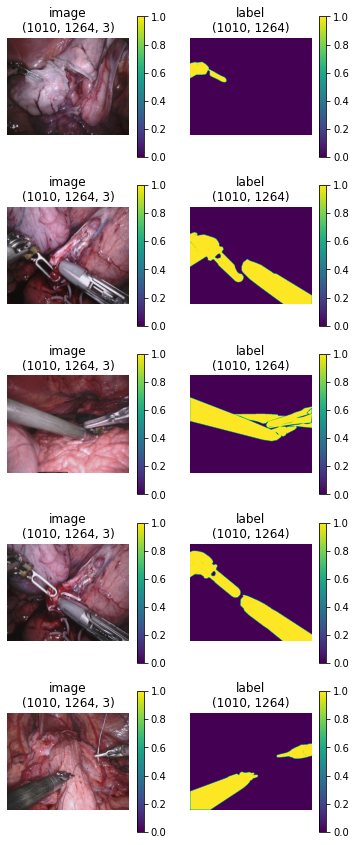

In [10]:
%matplotlib inline
def imshows(ims):
    nrow = len(ims)
    ncol = len(ims[0])
    fig, axes = plt.subplots(nrow, ncol, figsize=(
        ncol * 3, nrow * 3), facecolor='white')
    for i, im_dict in enumerate(ims):
        for j, (title, im) in enumerate(im_dict.items()):
            if isinstance(im, torch.Tensor):
                im = im.detach().cpu().numpy()
            # If RGB put, to end. Else, average across channel dim
            im = np.moveaxis(im, 0, -1) if im.shape[0] == 3 else np.mean(im, axis=0)

            ax = axes[j] if len(ims) == 1 else axes[i, j]
            ax.set_title(f"{title}\n{im.shape}")
            im_show = ax.imshow(im)
            ax.axis("off")
            fig.colorbar(im_show, ax=ax)

to_imshow = []
for data in np.random.choice(val_ds, size=5, replace=False):
    to_imshow.append({"image": data["image"], "label": data["label"]})
imshows(to_imshow)

In [11]:
def plot_range(data, wrapped_generator):
    # Get ax, show plot, etc.
    plt.ion()
    for d in data.values():
        ax = d["line"].axes
    fig = ax.get_figure()
    fig.show()

    for i in wrapped_generator:
        yield i
        # update plots, legend, view
        for d in data.values():
            d["line"].set_data(d["x"], d["y"])
        ax.legend()
        ax.relim()
        ax.autoscale_view()
        fig.canvas.draw()

In [12]:
# Create network, loss fn., etc.
dice_metric = DiceMetric(include_background=True, reduction="mean")
post_trans = Compose([
    Activations(sigmoid=True),
    AsDiscrete(threshold_values=True),
])
in_channels = train_ds[0]["image"].shape[0]
# create UNet, DiceLoss and Adam optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = UNet(
    dimensions=2,
    in_channels=in_channels,
    out_channels=1,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
).to(device)
loss_function = DiceLoss(sigmoid=True)
optimizer = torch.optim.Adam(model.parameters(), 1e-3)

In [13]:
min_pad = (val_size - orig_size) // 2
max_pad = val_size - orig_size - min_pad
# need to rev. order [::-1] because pad works from last dim working backwards
to_pad = tuple(np.ravel((min_pad[::-1], max_pad[::-1]), order='F').astype(int))
val_padder = lambda x: torch.nn.functional.pad(x, to_pad)
crop_slices = (...,) + tuple(slice(int(i), int(o + i)) for i, o in zip(min_pad, orig_size))
val_cropper = lambda x: x[crop_slices]

def infer_seg(images, model):
    i = val_padder(images)
    i = model(i)
    i = val_cropper(i)
    return post_trans(i)

In [14]:
%matplotlib notebook

best_model_path = "best_model_video_seg.pth"
always_train = False
do_training = always_train or not os.path.isfile(best_model_path)

if do_training:
    # Plotting stuff
    fig, ax = plt.subplots(1, 1, figsize=(10, 10), facecolor="white")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Metric")

    data = {}
    for i in ["train", "val dice"]:
        data[i] = {"x": [], "y": []}
        (data[i]["line"],) = ax.plot(data[i]["x"], data[i]["y"], label=i)

    # start a typical PyTorch training
    max_epochs = 20
    val_interval = 1
    best_metric = -1
    best_metric_epoch = -1

    for epoch in plot_range(data, range(max_epochs)):
        model.train()
        epoch_loss = 0

        for batch_data in train_dl:
            inputs, labels = batch_data["image"].to(
                device), batch_data["label"].to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        epoch_loss /= len(train_dl)
        data["train"]["x"].append(epoch + 1)
        data["train"]["y"].append(epoch_loss)

        if (epoch + 1) % val_interval == 0:
            with eval_mode(model):
                metric_sum = 0.0
                metric_count = 0
                val_outputs = None
                for val_data in val_dl:
                    val_images, val_labels = val_data["image"].to(
                        device), val_data["label"].to(device)
                    val_outputs = infer_seg(val_images, model)
                    value, _ = dice_metric(y_pred=val_outputs, y=val_labels)
                    metric_count += len(value)
                    metric_sum += value.item() * len(value)
                metric = metric_sum / metric_count
                data["val dice"]["x"].append(epoch + 1)
                data["val dice"]["y"].append(metric)
                if metric > best_metric:
                    best_metric = metric
                    best_metric_epoch = epoch + 1
                    torch.save(model.state_dict(), best_model_path)

    print(
        f"train completed, best_metric: {best_metric:.4f} at epoch: {best_metric_epoch}")

In [15]:
model.load_state_dict(torch.load(best_model_path))
_ = model.eval()

# Check segmentations

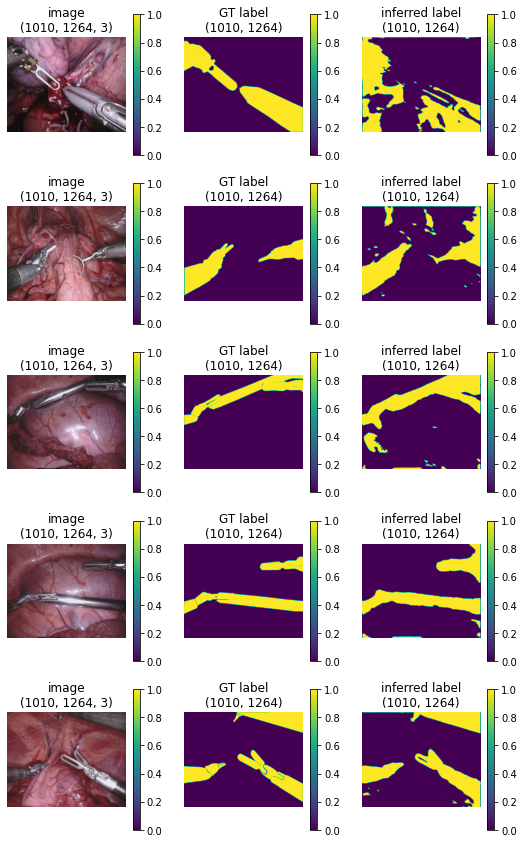

In [16]:
%matplotlib inline
to_imshow = []
for data in np.random.choice(val_ds, size=5, replace=False):
    im, label = data["image"], data["label"]
    im_gpu = im[None].to(device)
    inferred = infer_seg(im_gpu, model)[0]
    to_imshow.append({
        "image": im,
        "GT label": label,
        "inferred label": inferred,
    })
imshows(to_imshow)

## Time the inference

In [17]:
d =  val_transforms(val_file_dict[0])
im_gpu = d["image"][None].to(device)

%timeit infer_seg(im_gpu, model)

110 ms ± 258 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Generating video

In [18]:
import cv2

def create_video(in_files, output_file, fps, skip_if_present=False):
    codec = "X264" if output_file[-3:] == "mp4" else "MP42"
    fourcc = cv2.VideoWriter_fourcc(*codec)

    if skip_if_present and os.path.isfile(output_file):
        print(f"video alread present, skipping: {output_file}.")
        return
    print(f"{len(in_files)} frames @ {fps} fps: {output_file}...")

    for idx, image in enumerate(in_files):
        frame = cv2.imread(image)
        if idx == 0:
            width_height = frame.shape[:-1][::-1]
            video = cv2.VideoWriter(output_file, fourcc, fps, width_height)
        video.write(frame)
    video.release()
    if not os.path.isfile(output_file):
        raise RuntimeError("video not created:", output_file)

def create_videos(folder, fps):
    vid_dir = folder + "_videos"
    os.makedirs(vid_dir, exist_ok=True)
    vid_idx = 1
    image_vids, label_vids = [], []
    while True:
        images = sorted(glob(os.path.join(folder, f"d{vid_idx}*[!seg].png")))
        labels = sorted(glob(os.path.join(folder, f"d{vid_idx}*_seg.png")))
        if len(images) == 0:
            break
        image_vids.append(os.path.join(vid_dir, f"d{vid_idx}_im.mp4"))
        label_vids.append(os.path.join(vid_dir, f"d{vid_idx}_seg.mp4"))
        create_video(images, image_vids[-1], fps, skip_if_present=True)
        create_video(labels, label_vids[-1], fps, skip_if_present=True)

        vid_idx += 1
    return image_vids, label_vids

# endovis2017 is 2Hz:
# https://endovissub2017-roboticinstrumentsegmentation.grand-challenge.org/
fps = 2
train_image_vids, train_label_vids = create_videos(train_dir, fps)
val_image_vids, val_label_vids = create_videos(val_dir, fps)

video alread present, skipping: /home/rbrown/data/MONAI/endovis_2017/train_videos/d1_im.mp4.
video alread present, skipping: /home/rbrown/data/MONAI/endovis_2017/train_videos/d1_seg.mp4.
video alread present, skipping: /home/rbrown/data/MONAI/endovis_2017/train_videos/d2_im.mp4.
video alread present, skipping: /home/rbrown/data/MONAI/endovis_2017/train_videos/d2_seg.mp4.
video alread present, skipping: /home/rbrown/data/MONAI/endovis_2017/train_videos/d3_im.mp4.
video alread present, skipping: /home/rbrown/data/MONAI/endovis_2017/train_videos/d3_seg.mp4.
video alread present, skipping: /home/rbrown/data/MONAI/endovis_2017/train_videos/d4_im.mp4.
video alread present, skipping: /home/rbrown/data/MONAI/endovis_2017/train_videos/d4_seg.mp4.
video alread present, skipping: /home/rbrown/data/MONAI/endovis_2017/train_videos/d5_im.mp4.
video alread present, skipping: /home/rbrown/data/MONAI/endovis_2017/train_videos/d5_seg.mp4.
video alread present, skipping: /home/rbrown/data/MONAI/endovis_2

In [21]:
# from ipywebrtc import VideoStream
# video = VideoStream.from_file(train_image_vids[-1])
# video


# from IPython.display import HTML

# video_path = train_image_vids[-1]

# HTML("""
# <video width="840" height="460" controls="">
# <source src="{0}">
# </video>
# """.format(video_path))

ModuleNotFoundError: No module named 'ipywebrtc'

## Optical flow

In [ ]:
import cv2 as cv
from monai.transforms import LoadImage

flow_args = {}
flow_args["pyr_scale"] = 0.5   # each pyramid is half previous
flow_args["levels"] = 3        # num pyramid levels
flow_args["winsize"] = 15      # averaging window size. larger==robust, better for fast 
                               # motion detection but more blurred motion fields
flow_args["iterations"] = 5    # num iters per pyramid level
flow_args["poly_n"] = 5        # size of pixel neighbourhood. larger == smoother
                               # surfaces -> robust but blurred
flow_args["poly_sigma"] = 1.1  # std dev of Gaussian smoothing. 1.1 good for 
                               # poly_n==5. 1.7 good for poly_n==7

def get_im(idx):
    loader = LoadImage(image_only=True)
    return (loader(val_file_dict[idx][i]) for i in ["image", "label"])

def get_flow(old_im, new_im, old_flow=None):
    flags = 0 if old_flow is None else cv.OPTFLOW_USE_INITIAL_FLOW
    old_gray = cv.cvtColor(old_im, cv.COLOR_BGR2GRAY)
    new_gray = cv.cvtColor(new_im, cv.COLOR_BGR2GRAY)
    flow = cv.calcOpticalFlowFarneback(old_gray, new_gray, old_flow, flags=flags, **flow_args) 
    return flow

def get_flow_nvidia(old_im, new_im, old_flow=None):
    flags = 0 if old_flow is None else cv.OPTFLOW_USE_INITIAL_FLOW
    old_gray = cv.cvtColor(old_im, cv.COLOR_BGR2GRAY)
    new_gray = cv.cvtColor(new_im, cv.COLOR_BGR2GRAY)
    old_cuMat = cv.cuda_GpuMat(old_gray)
    new_cuMat = cv.cuda_GpuMat(new_gray)
    nvid_flow = cv2.cuda_FarnebackOpticalFlow.create(5, 0.5, False, 15, 3, 5, 1.2, 0)
    flow = cv2.cuda_FarnebackOpticalFlow.calc(nvid_flow, old_cuMat, new_cuMat, None)
    return flow

def flow_to_bgr(flow):
    shape = flow.shape[:-1] + (flow.shape[-1]+1,)
    hsv = np.zeros(shape)
    hsv[..., 1] = 255
    mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])
    hsv[..., 0] = ang * 180 / np.pi / 2
    hsv[..., 2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)
    bgr = cv2.cvtColor(hsv.astype(np.uint8), cv2.COLOR_HSV2BGR)
    return bgr

def flow_to_bgr_nvidia(gpu_flow):
    print(gpu_flow.shape)
    return
    shape = gpu_flow.shape[:-1] + (gpu_flow.shape[-1]+1,)
    # create gpu_hsv output for optical flow
    gpu_hsv = cv2.cuda_GpuMat(shape, cv2.CV_32FC3)
    gpu_hsv_8u = cv2.cuda_GpuMat(shape, cv2.CV_8UC3)

    gpu_h = cv2.cuda_GpuMat(gpu_frame.size(), cv2.CV_32FC1)
    gpu_s = cv2.cuda_GpuMat(gpu_frame.size(), cv2.CV_32FC1)
    gpu_v = cv2.cuda_GpuMat(gpu_frame.size(), cv2.CV_32FC1)

    # set saturation to 1
    gpu_s.upload(np.ones_like(previous_frame, np.float32))
    
    gpu_flow_x = cv2.cuda_GpuMat(gpu_flow.size(), cv2.CV_32FC1)
    gpu_flow_y = cv2.cuda_GpuMat(gpu_flow.size(), cv2.CV_32FC1)
    cv2.cuda.split(gpu_flow, [gpu_flow_x, gpu_flow_y])

    # convert from cartesian to polar coordinates to get magnitude and angle
    gpu_magnitude, gpu_angle = cv2.cuda.cartToPolar(
        gpu_flow_x, gpu_flow_y, angleInDegrees=True,
    )

    # set value to normalized magnitude from 0 to 1
    gpu_v = cv2.cuda.normalize(gpu_magnitude, 0.0, 1.0, cv2.NORM_MINMAX, -1)

    # get angle of optical flow
    angle = gpu_angle.download()
    angle *= (1 / 360.0) * (180 / 255.0)

    # set hue according to the angle of optical flow
    gpu_h.upload(angle)

    # merge h,s,v channels
    cv2.cuda.merge([gpu_h, gpu_s, gpu_v], gpu_hsv)

    # multiply each pixel value to 255
    gpu_hsv.convertTo(cv2.CV_8U, 255.0, gpu_hsv_8u, 0.0)

    # convert hsv to bgr
    gpu_bgr = cv2.cuda.cvtColor(gpu_hsv_8u, cv2.COLOR_HSV2BGR)

    # send original frame from GPU back to CPU
    frame = gpu_frame.download()

    # send result from GPU back to CPU
    bgr = gpu_bgr.download()

    # update previous_frame value
    gpu_previous = gpu_current
    
def warp_flow(img, flow):
    h, w = flow.shape[:2]
    flow = -flow
    flow[:, :, 0] += np.arange(w)
    flow[:, :, 1] += np.arange(h)[:, np.newaxis]
    res = cv2.remap(img, flow, None, cv2.INTER_LINEAR)
    return res

old_im, old_label = get_im(0)
new_im, new_label = get_im(1)
flow = get_flow(old_im, new_im)
flow_nvidia = get_flow_nvidia(old_im, new_im)
a = flow_to_bgr_nvidia(flow_nvidia)

to_imshow = []
to_imshow.append({
    "frame 0": np.moveaxis(old_im / 255, -1, 0),
    "frame 1": np.moveaxis(new_im / 255, -1, 0),
    "flow": np.moveaxis(flow_to_bgr(flow), -1, 0),
    "flow_nvidia": np.moveaxis(flow_to_bgr_nvidia(flow_nvidia), -1, 0),
    
})
to_imshow.append({
    "seg 0": old_label[None],
    "seg 1": new_label[None],
    "seg 2": new_label[None],
})
imshows(to_imshow)

In [ ]:
prev_frame = get_im(1)
current_frame = get_im(2)
flow = get_flow(prev_frame, current_frame, flow)

fig, axes = plt.subplots(1,3, figsize=(25,14))
axes[0].imshow(prev_frame / 255)
axes[1].imshow(current_frame / 255)
axes[2].imshow(flow_to_bgr(flow))

In [ ]:
help(cv.cuda_FarnebackOpticalFlow)

In [ ]:
frame1 = (cv2.imread(val_file_dict[0]["image"], cv2.IMREAD_GRAYSCALE))
frame2 = (cv2.imread(val_file_dict[1]["image"], cv2.IMREAD_GRAYSCALE))
print(frame1.shape[0])

nvof = cv2.cuda_NvidiaOpticalFlow_1_0.create(frame1.shape[1], frame1.shape[0], 5, False, False, False, 0)

# flow = nvof.calc(frame1, frame2, None)

# flowUpSampled = nvof.upSampler(flow[0], frame1.shape[1], frame1.shape[0], nvof.getGridSize(), None)

# cv2.writeOpticalFlow('OpticalFlow.flo', flowUpSampled)

# nvof.collectGarbage()

In [ ]:
help(cv2.cuda_FarnebackOpticalFlow)

In [ ]:
cv2.cuda_FarnebackOpticalFlow(frame1, frame2, None, flags=flags, **flow_args)

In [ ]:
test_path = "/home/rbrown/opencv/Source/samples/data"

import numpy as np 
import cv2

frame1 = (cv2.imread(os.path.join(test_path, 'basketball1.png'), cv2.IMREAD_GRAYSCALE))
frame2 = (cv2.imread(os.path.join(test_path, 'basketball2.png'), cv2.IMREAD_GRAYSCALE))

nvof = cv2.cuda_NvidiaOpticalFlow_1_0.create(frame1.shape[1], frame1.shape[0], 5, False, False, False, 0)

flow = nvof.calc(frame1, frame2, None)

flowUpSampled = nvof.upSampler(flow[0], frame1.shape[1], frame1.shape[0], nvof.getGridSize(), None)

cv2.writeOpticalFlow('OpticalFlow.flo', flowUpSampled)

nvof.collectGarbage()

In [ ]:
frame1 = os.path.join(test_path, 'basketball1.png')
frame2 = os.path.join(test_path, 'basketball2.png')
print(frame1)

npMat1 = cv.cvtColor(cv.imread(frame1),cv.COLOR_BGR2GRAY)
npMat2 = cv.cvtColor(cv.imread(frame2),cv.COLOR_BGR2GRAY)

cuMat1 = cv.cuda_GpuMat(npMat1)
cuMat2 = cv.cuda_GpuMat(npMat2)
try:
    nvof = cv.cuda_NvidiaOpticalFlow_1_0.create(cuMat1.shape[1], cuMat1.shape[0], 5, False, False, False, 0)
    flow = nvof.calc(cuMat1, cuMat2, None)
    self.assertTrue(flow.shape[1] > 0 and flow.shape[0] > 0)
    flowUpSampled = nvof.upSampler(flow[0], cuMat1.shape[1], cuMat1.shape[0], nvof.getGridSize(), None)
    nvof.collectGarbage()
except cv.error as e:
    if e.code == cv.Error.StsBadFunc or e.code == cv.Error.StsBadArg or e.code == cv.Error.StsNullPtr:
        self.skipTest("Algorithm is not supported in the current environment")
self.assertTrue(flowUpSampled.shape[1] > 0 and flowUpSampled.shape[0] > 0)

In [ ]:
import numpy as np
import os
import cv2
from monai.data import create_test_image_2d, write_png


def create_video(in_files, output_file_no_ext, fps, skip_if_present=True):
    exts = [".mp4", ".avi"]
    codecs = ["X264", "MP42"]
    for ex, co in zip(exts, codecs):
        output_file = output_file_no_ext + ex
        fourcc = cv2.VideoWriter_fourcc(*co)

        if skip_if_present and os.path.isfile(output_file):
            print(f"video alread present, skipping: {output_file}.")
            continue
        print(f"{len(in_files)} frames @ {fps} fps: {output_file}...")

        for idx, image in enumerate(in_files):
            frame = cv2.imread(image)
            if idx == 0:
                width_height = frame.shape[:-1][::-1]
                video = cv2.VideoWriter(output_file, fourcc, fps, width_height)
            video.write(frame)
        video.release()


        
path = "/home/rbrown/data/MONAI/opencv_test/output2"
os.makedirs(path, exist_ok=True)
fps = 2

# num_frames = 202
# width, height = 1024, 1264
# fnames = [os.path.join(path, f"frame_{i}.png") for i in range(num_frames)]
# for fname in fnames:
#     out_range = 255
#     im = create_test_image_2d(width, height)[0] * out_range
#     im_rgb = np.repeat(im[..., np.newaxis], 3, axis=-1)
    
#     write_png(im_rgb, fname, scale=out_range)

create_video(fnames, os.path.join(path, "test"), fps, False)
images = sorted(glob(os.path.join(train_dir, f"d1*[!seg].png")))
create_video(images, os.path.join(path, "test_real"), fps, False)
